In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import add_dummy_feature
from sklearn.preprocessing import label_binarize


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
import mord

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

from scipy import interp

### Load and Explore Data

In [2]:
df = pd.read_csv('winequality-red.csv', delimiter=';')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Subset Data

In [4]:
df_subset = df.copy()
df_subset['quality2'] = pd.cut(df.quality, bins=3, labels=[1, 2, 3])
df_subset['quality2'] = df_subset['quality2'].astype(int)

In [5]:
df_subset['quality2'].value_counts(sort=False)

1      63
2    1319
3     217
Name: quality2, dtype: int64

In [6]:
df_subset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality2
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,2
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,2


### Split Data 

In [7]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [8]:
# Split 
# y = df_subset.quality2
# X = df_subset.drop(columns=['quality', 'quality2'])

y = df.quality
X = df.drop(columns='quality')

# # Make sure intercept exists
# if ~any(X.columns == 'Intercept'):
#     X.insert(0, 'Intercept', 1)
# else: 
#     X.Intercept = 1
    
# Stratified Split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, test_size=.5, random_state=129)

### Bootstrap Resampling

In [9]:
def resample_df(df, target_col, n_samples=None, replace=True):
    
    levels = df[target_col].unique()
    cnts = df[target_col].value_counts()
    
    if n_samples is None:
        n_samples = np.max(cnts)
    elif n_samples == 'max':
        n_samples = np.max(cnts)
    elif n_samples == 'min':
        n_samples = np.min(cnts)    
    elif n_samples == 'med':
        n_samples = np.median(cnts)
        
    df_resampled = pd.DataFrame()    
    for target_class in df[target_col].unique():
        
        df_target_class = df[df[target_col] == target_class]
        df_target_resampled = resample(df_target_class, 
                                       replace=replace,
                                       n_samples=n_samples,
                                       random_state=129)
        df_resampled = pd.concat([df_resampled, df_target_resampled], axis=0)
        
    return df_resampled           

In [10]:
df_train_resampled = resample_df(pd.concat([X_train, y_train], axis=1) , 'quality', n_samples='max')
X_train = df_train_resampled.drop(columns='quality')
y_train = df_train_resampled['quality']

In [11]:
df_test_resampled = resample_df(pd.concat([X_test, y_test], axis=1) , 'quality', n_samples='max')
X_test = df_test_resampled.drop(columns='quality')
y_test = df_test_resampled['quality']

In [12]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
609,6.3,0.36,0.19,3.2,0.075,15.0,39.0,0.99560,3.56,0.52,12.7
204,7.0,0.43,0.36,1.6,0.089,14.0,37.0,0.99615,3.34,0.56,9.2
918,8.4,0.36,0.32,2.2,0.081,32.0,79.0,0.99640,3.30,0.72,11.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
564,13.0,0.47,0.49,4.3,0.085,6.0,47.0,1.00210,3.30,0.68,12.7


In [13]:
df_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 609 to 455
Data columns (total 12 columns):
fixed acidity           2040 non-null float64
volatile acidity        2040 non-null float64
citric acid             2040 non-null float64
residual sugar          2040 non-null float64
chlorides               2040 non-null float64
free sulfur dioxide     2040 non-null float64
total sulfur dioxide    2040 non-null float64
density                 2040 non-null float64
pH                      2040 non-null float64
sulphates               2040 non-null float64
alcohol                 2040 non-null float64
quality                 2040 non-null int64
dtypes: float64(11), int64(1)
memory usage: 207.2 KB


In [14]:
X_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
641,9.5,0.59,0.44,2.3,0.071,21.0,68.0,0.99920,3.46,0.63,9.5
163,7.4,0.60,0.26,7.3,0.070,36.0,121.0,0.99820,3.37,0.49,9.4
192,6.8,0.63,0.12,3.8,0.099,16.0,126.0,0.99690,3.28,0.61,9.5
1288,7.0,0.60,0.30,4.5,0.068,20.0,110.0,0.99914,3.30,1.17,10.2
1262,9.8,0.45,0.38,2.5,0.081,34.0,66.0,0.99726,3.15,0.58,9.8


In [15]:
df_test_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2046 entries, 641 to 1374
Data columns (total 12 columns):
fixed acidity           2046 non-null float64
volatile acidity        2046 non-null float64
citric acid             2046 non-null float64
residual sugar          2046 non-null float64
chlorides               2046 non-null float64
free sulfur dioxide     2046 non-null float64
total sulfur dioxide    2046 non-null float64
density                 2046 non-null float64
pH                      2046 non-null float64
sulphates               2046 non-null float64
alcohol                 2046 non-null float64
quality                 2046 non-null int64
dtypes: float64(11), int64(1)
memory usage: 207.8 KB


In [16]:
set(df_train_resampled.index).intersection(set(df_test_resampled.index))

set()

### Helper Functions

In [17]:
def normalize_confusion_matrix(cm):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    
    #     cm = (cm - np.min(cm)) / (np.max(cm) - np.min(cm))
    
    return cm

In [18]:
def discrete_heatmap(cm):
    
    ### Discrete Confusion Matrix Heatmap
    from sklearn.preprocessing import normalize
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(figsize=(10, 6))
    
    Z = normalize_confusion_matrix(cm)

    # Generate heatmap
    ax = sns.heatmap(Z, ax=ax, cmap='RdYlGn', annot=True, cbar=True,
                     vmin=0, vmax=1, cbar_kws={'ticks': np.arange(0, 1.2, 0.2)})
    
    ## Format axes object
    #  Format X-axis label and ticks
    ax.set_xlabel('Predicted', fontdict={'size': 12})
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    ax.set_xticklabels(['Low', 'Med', 'High'], minor=False)
    
    # Format Y-axis label
    ax.set_ylabel('Truth', fontdict={'size': 12})
    ax.set_yticklabels(['High', 'Med', 'Low'], minor=False)
    
    # Format Title [Note: double newlines are to create space between Title and the X-axis label that was moved to the top]
    ax.set_title('Red Wine Quality Confusion Matrix\n\n', fontdict={'size': 14, 'weight': 'bold'})

In [19]:
def interpolated_heatmap(cm):
    
    ### Interpolated Confusion Matrix Heatmap
    import numpy as np
    from sklearn.preprocessing import normalize
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.patch.set_visible(False)
    
    Z = normalize_confusion_matrix(cm)

    # Generate X, Y indices of confusion matrix
    n_classes = Z.shape[0]
    X, Y = np.meshgrid(np.arange(0, n_classes, 1), np.arange(n_classes-1, -1, -1))

    # Plot contours
    plt.contourf(X, Y, Z, 25, cmap='RdYlGn', vmin=0, vmax=1, )
    ax2 = plt.colorbar(ticks=np.arange(0, 1.2, 0.2))
    
    ## Format X-axis label and ticks
    ax.set_xlabel('Predicted', fontdict={'size': 12})
    # Move ticks and label to top
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    # Hide major tick labels
    ax.set_xticklabels([], minor=False) 
    ax.set_xticks([0, 2], minor=False)
    # Define and label minor ticks
    ax.set_xticks([0.3, 1, 1.7], minor=True)
    ax.set_xticklabels(['Low', 'Mid', 'High'], minor=True)

    ## Format Y-axis label and ticks
    ax.set_ylabel('Truth', fontdict={'size': 12})
    # Hide major tick labels
    ax.set_yticklabels([], minor=False)    
    # Create and label minor ticks
    ax.set_yticks([0.3, 1, 1.7], minor=True)
    ax.set_yticks([0, 2], minor=False)
    ax.set_yticklabels(['High', 'Mid', 'Low'], minor=True)

    # Format Title [Note: double newlines are to create space between Title 
    # and the X-axis label that was moved to the top]
    ax.set_title('Red Wine Quality\n\n', fontdict={'size': 14, 'weight': 'bold'})

### Build Models

In [20]:
def error_distance_cost(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    cm = normalize_confusion_matrix(cm)
    
    cost = np.zeros_like(cm)
    rows, cols = cm.shape
    for ridx in range(rows):
        for cidx in range(cols):
            cost[ridx, cidx] = np.abs(ridx-cidx) * cm[ridx, cidx]

    return np.around(1/np.sum(cost), decimals=5)

def f1(y_true, y_pred):
    
    return f1_score(y_true, y_pred, average='macro')

In [21]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [22]:
lr2 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='ovr',
                         solver='liblinear')
lr2.fit(X_train, y_train)

print(lr2)

# make predictions
lr2_pred = lr2.predict(X_test)
lr2_probas = lr2.predict_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr2_pred))
print(confusion_matrix(y_test, lr2_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=129,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          3       0.00      0.00      0.00       341
          4       0.31      0.40      0.35       341
          5       0.37      0.63      0.46       341
          6       0.39      0.22      0.28       341
          7       0.37      0.53      0.44       341
          8       0.47      0.42      0.44       341

avg / total       0.32      0.37      0.33      2046

[[  0 198 143   0   0   0]
 [ 26 137 113  39   0  26]
 [  4  45 214  47  20  11]
 [  4  51  89  76  85  36]
 [  3  16  21  32 182  87]
 [  0   0   0   0 199 142]]


In [23]:
# result = pd.concat([pd.Series(lr2_pred, name='Pred').reset_index(drop=True), 
#                     pd.Series(y_test, name='Truth').reset_index(drop=True),
#                     pd.DataFrame(lr2_probas, columns=[1, 2, 3]).reset_index(drop=True)], axis=1)

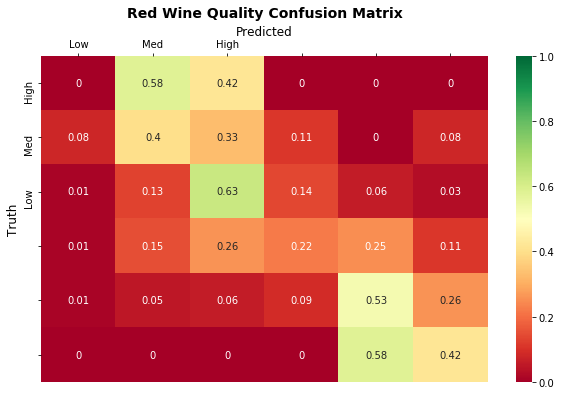

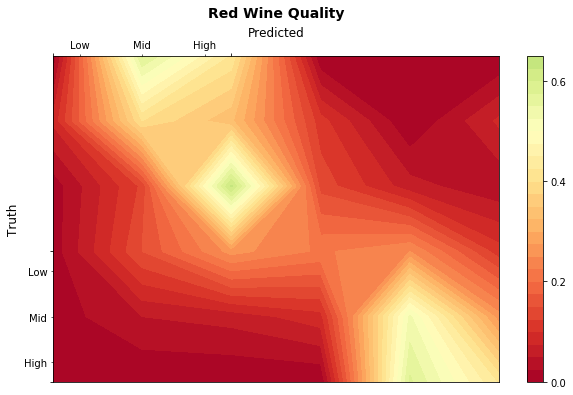

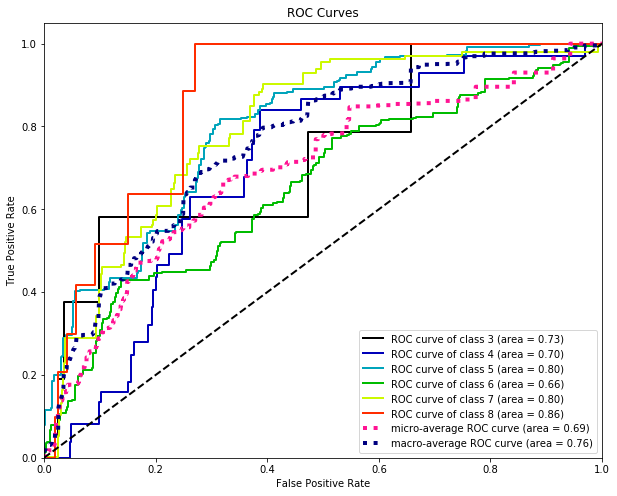

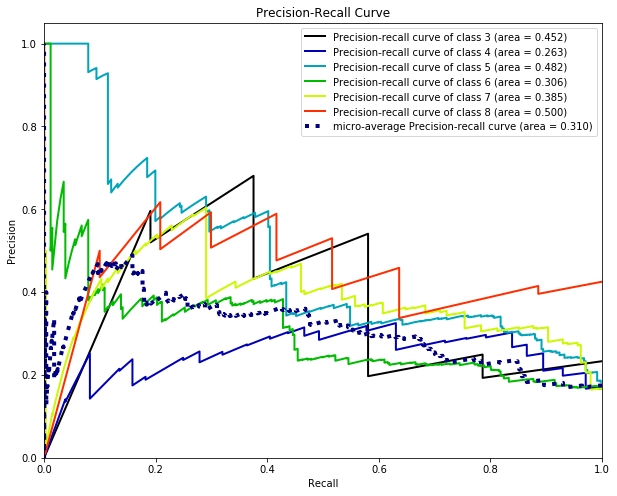

In [24]:
discrete_heatmap(confusion_matrix(y_test, lr2_pred))

interpolated_heatmap(confusion_matrix(y_test, lr2_pred))

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr2_probas, ax=ax)

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr2_probas, ax=ax)

In [25]:
pipe2 = make_pipeline(StandardScaler(), lr2)

pipe2.fit(X_train, y_train)

print(pipe2)

# make predictions
pipe2_pred = pipe2.predict(X_test)
pipe2_probas = pipe2.predict_proba(X_test)
pipe2_conf = pipe2.decision_function(X_test)

# summarize the fit of the model
print(classification_report(y_test, pipe2_pred))
print(confusion_matrix(y_test, pipe2_pred))

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=129,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
             precision    recall  f1-score   support

          3       0.00      0.00      0.00       341
          4       0.29      0.38      0.33       341
          5       0.37      0.61      0.46       341
          6       0.36      0.23      0.28       341
          7       0.40      0.58      0.47       341
          8       0.46      0.42      0.44       341

avg / total       0.31      0.37      0.33      2046

[[  0 198 143   0   0   0]
 [ 10 130 103  62   0  36]
 [  4  51 209  46  16  15]
 [  2  51  86  77  86  39]
 [  0  19  19  27 199  77]
 [  0   0   0   0 199 142]]

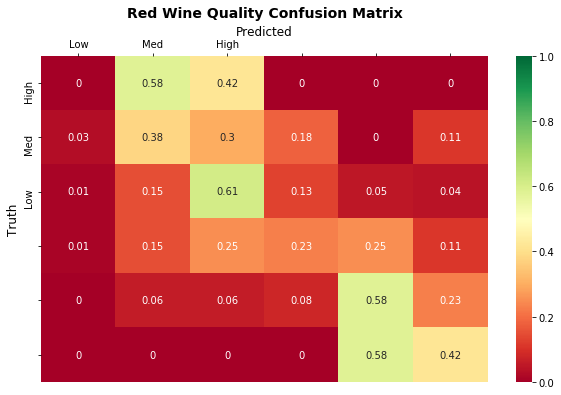

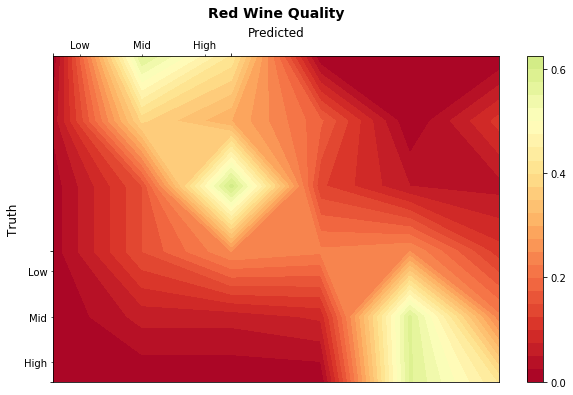

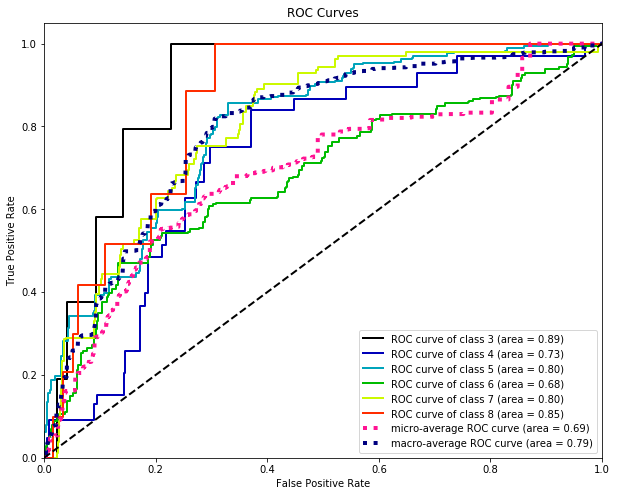

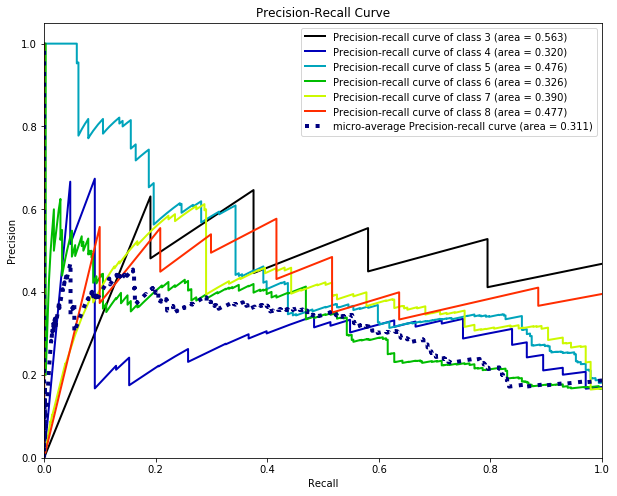

In [26]:
discrete_heatmap(confusion_matrix(y_test, pipe2_pred))

interpolated_heatmap(confusion_matrix(y_test, pipe2_pred))

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, pipe2_probas, ax=ax)

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, pipe2_probas, ax=ax)

In [27]:
lr3 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='newton-cg', max_iter=1000)
lr3.fit(X_train, y_train)

print(lr3)

# make predictions
lr3_pred = lr3.predict(X_test)
lr3_probas = lr3.predict_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr3_pred))
print(confusion_matrix(y_test, lr3_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          3       0.00      0.00      0.00       341
          4       0.25      0.39      0.31       341
          5       0.43      0.54      0.48       341
          6       0.37      0.33      0.35       341
          7       0.34      0.53      0.42       341
          8       0.44      0.30      0.36       341

avg / total       0.31      0.35      0.32      2046

[[  0 268  73   0   0   0]
 [ 26 132  95  62  14  12]
 [  4  57 183  79  13   5]
 [  2  49  65 111  87  27]
 [  0  14  13  46 182  86]
 [  0   0   0   0 239 102]]


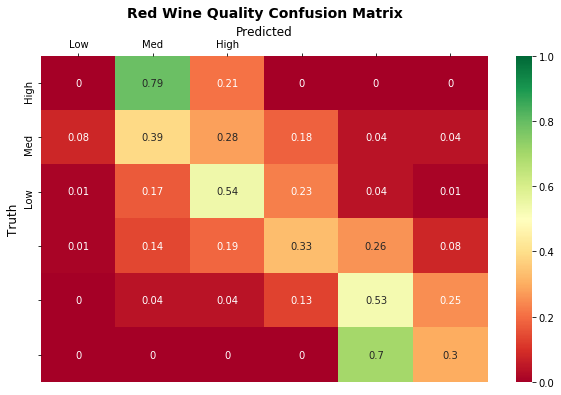

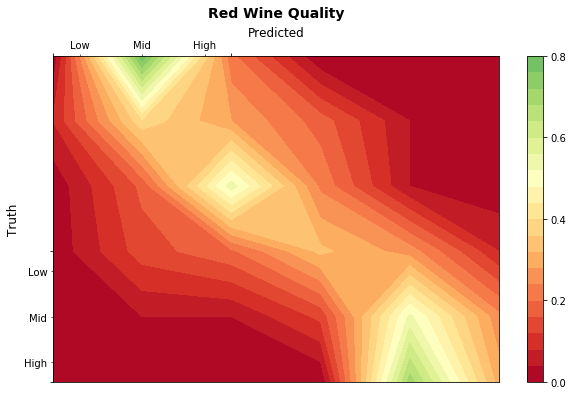

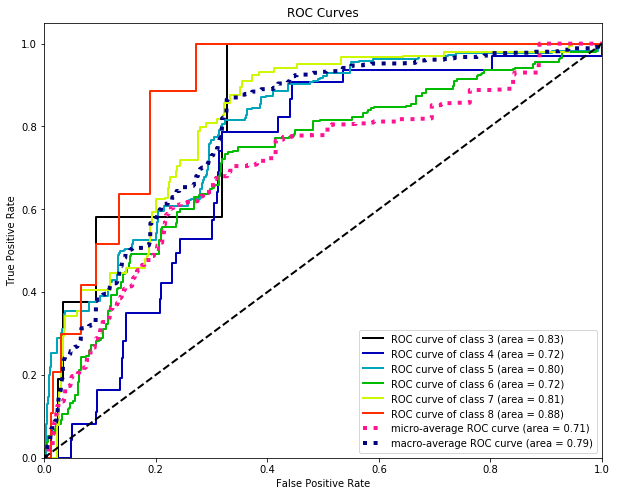

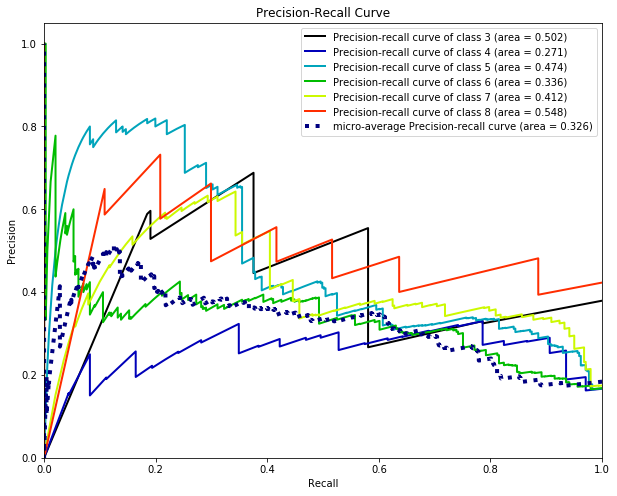

In [28]:
discrete_heatmap(confusion_matrix(y_test, lr3_pred))

interpolated_heatmap(confusion_matrix(y_test, lr3_pred))

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr3_probas, ax=ax)

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr3_probas, ax=ax)

In [29]:
pipe3 = make_pipeline(StandardScaler(), lr3)

pipe3.fit(X_train, y_train)

print(pipe3)

# make predictions
pipe3_pred = pipe3.predict(X_test)
pipe3_probas = pipe3.predict_proba(X_test)
pipe3_conf = pipe3.decision_function(X_test)

# summarize the fit of the model
print(classification_report(y_test, pipe3_pred))
print(confusion_matrix(y_test, pipe3_pred))

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False))])
             precision    recall  f1-score   support

          3       0.00      0.00      0.00       341
          4       0.36      0.52      0.43       341
          5       0.39      0.54      0.45       341
          6       0.38      0.34      0.36       341
          7       0.37      0.54      0.44       341
          8       0.53      0.42      0.47       341

avg / total       0.34      0.39      0.36      2046

[[  0 198 143   0   0   0]
 [ 10 176  67  62  14  12]
 [  4  53 183  81  15   5]
 [  2  43  64 117  90  25]
 [  0  14  13  44 185  85]
 [  0   

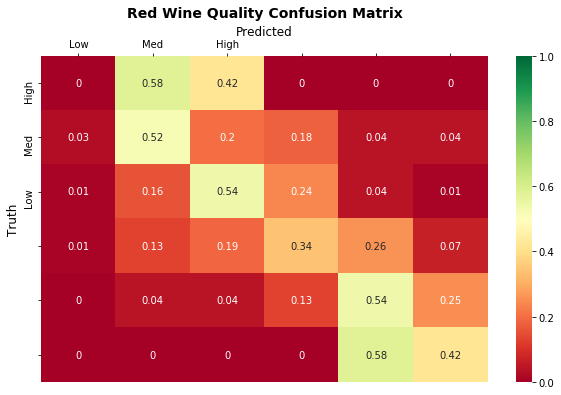

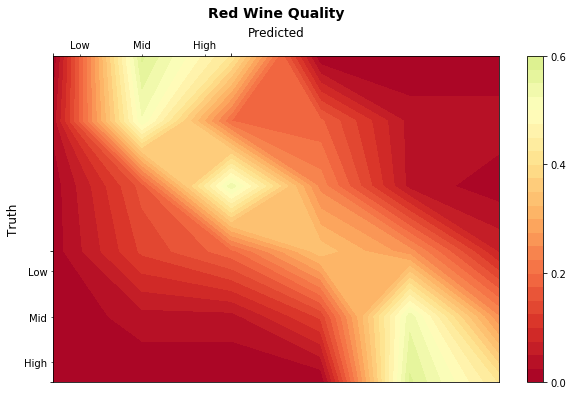

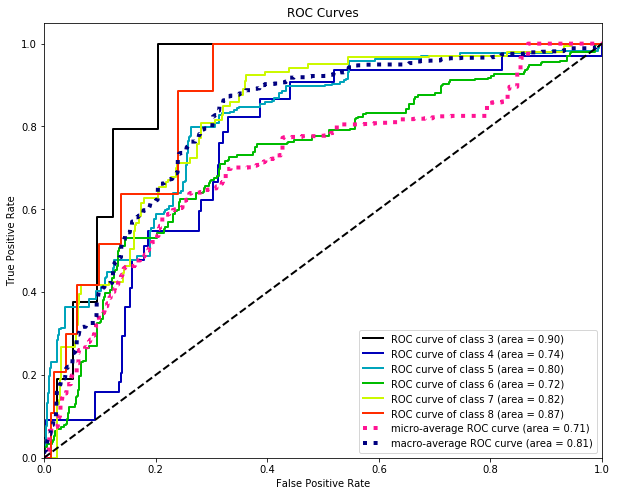

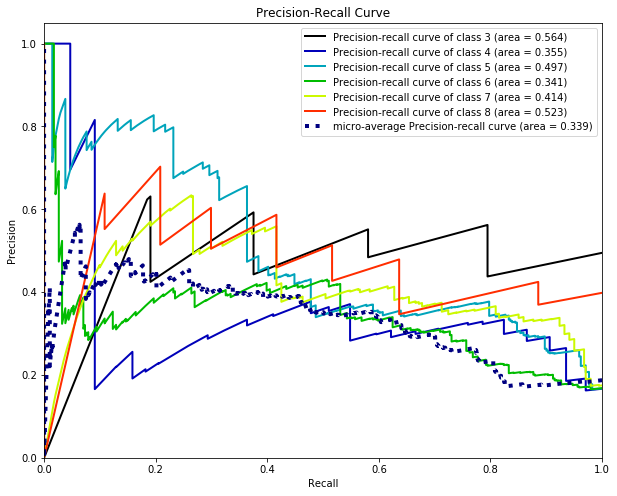

In [30]:
discrete_heatmap(confusion_matrix(y_test, pipe3_pred))

interpolated_heatmap(confusion_matrix(y_test, pipe3_pred))

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, pipe3_probas, ax=ax)

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, pipe3_probas, ax=ax)

In [31]:
lr4 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='lbfgs')
lr4.fit(X_train, y_train)

print(lr4)

# make predictions
lr4_pred = lr4.predict(X_test)
lr4_probas = lr4.predict_log_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr4_pred))
print(confusion_matrix(y_test, lr4_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          3       0.25      0.21      0.23       341
          4       0.30      0.32      0.31       341
          5       0.35      0.49      0.41       341
          6       0.49      0.24      0.32       341
          7       0.35      0.27      0.30       341
          8       0.43      0.64      0.51       341

avg / total       0.36      0.36      0.35      2046

[[ 70 128 143   0   0   0]
 [ 87 109  92  10  28  15]
 [ 27  66 167  53  13  15]
 [ 26  53  60  81  46  75]
 [ 26   5  13  23  91 183]
 [ 39   0   0   0  85 217]]


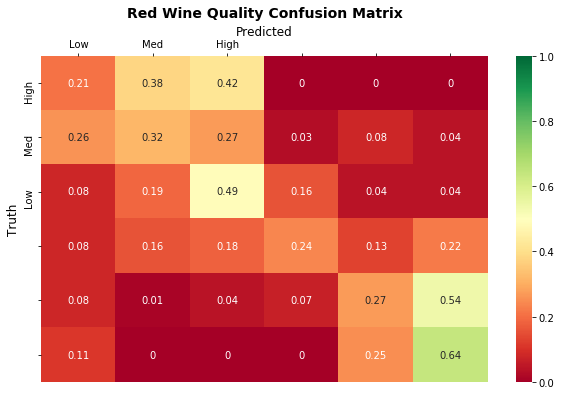

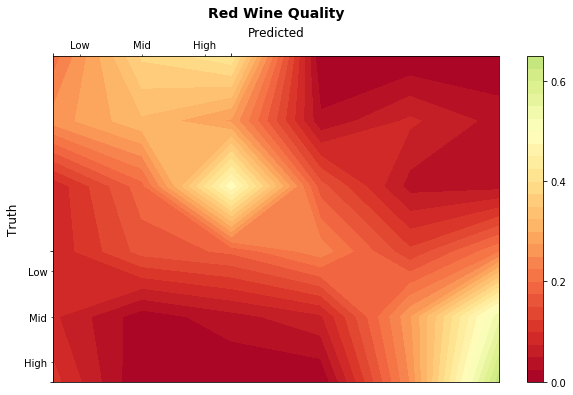

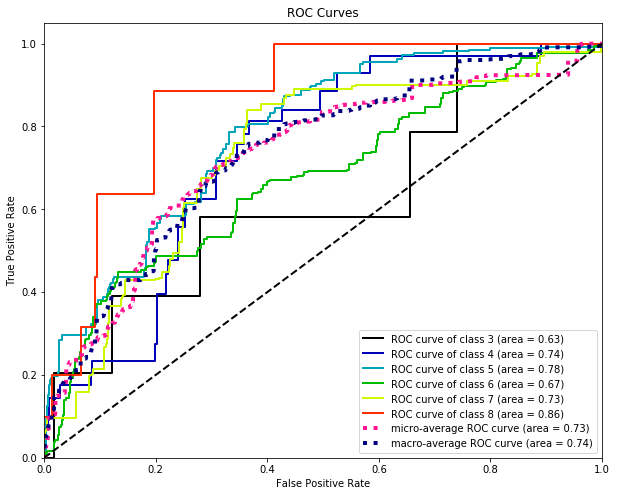

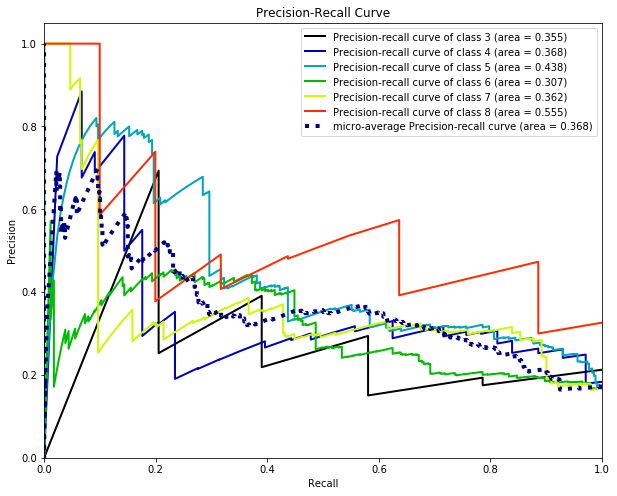

In [32]:
discrete_heatmap(confusion_matrix(y_test, lr4_pred))

interpolated_heatmap(confusion_matrix(y_test, lr4_pred))

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr4_probas, ax=ax)

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr4_probas, ax=ax)

In [33]:
pipe4 = make_pipeline(StandardScaler(), lr4)

pipe4.fit(X_train, y_train)

print(pipe4)

# make predictions
pipe4_pred = pipe4.predict(X_test)
pipe4_probas = pipe4.predict_proba(X_test)
pipe4_conf = pipe4.decision_function(X_test)

# summarize the fit of the model
print(classification_report(y_test, pipe4_pred))
print(confusion_matrix(y_test, pipe4_pred))

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False))])
             precision    recall  f1-score   support

          3       0.00      0.00      0.00       341
          4       0.36      0.52      0.43       341
          5       0.39      0.53      0.45       341
          6       0.39      0.35      0.37       341
          7       0.37      0.54      0.44       341
          8       0.52      0.42      0.46       341

avg / total       0.34      0.39      0.36      2046

[[  0 198 143   0   0   0]
 [ 10 176  67  62  14  12]
 [  4  50 181  83  15   8]
 [  0  45  60 121  91  24]
 [  0  14  13  44 185  85]
 [  0   0   0

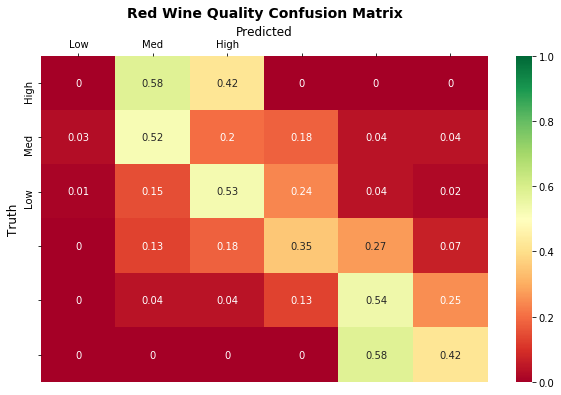

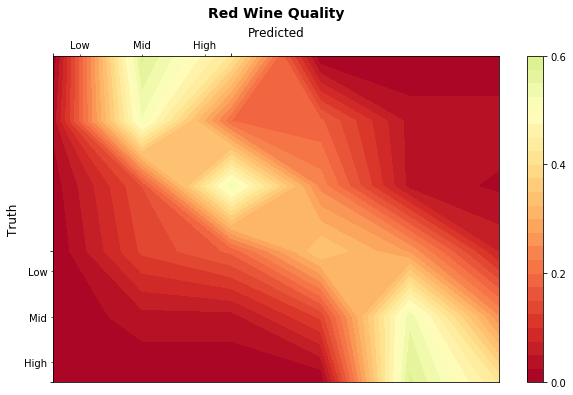

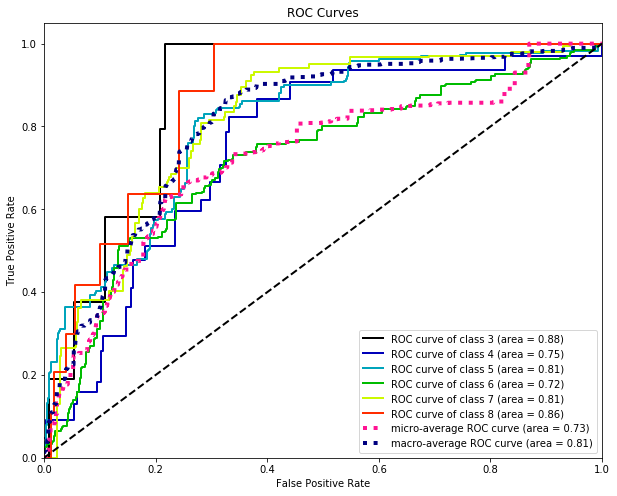

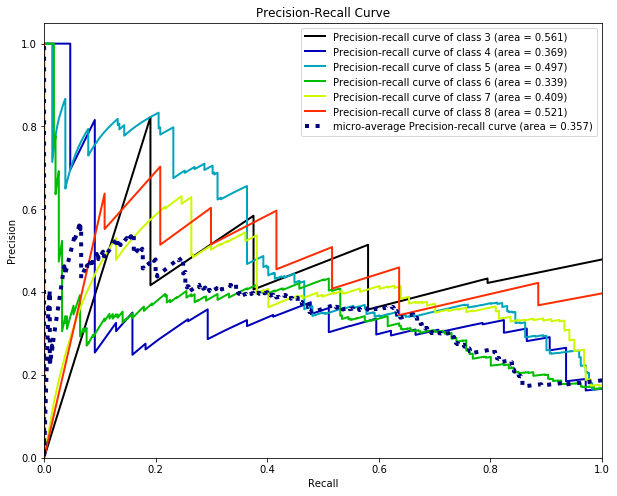

In [34]:
discrete_heatmap(confusion_matrix(y_test, pipe4_pred))

interpolated_heatmap(confusion_matrix(y_test, pipe4_pred))

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, pipe4_probas, ax=ax)

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, pipe4_probas, ax=ax)

In [35]:
lr5 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='sag',
                         max_iter=10000*2.5)
lr5.fit(X_train, y_train)

print(lr5)

# make predictions
lr5_pred = lr5.predict(X_test)
lr5_probas = lr5.predict_log_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr5_pred))
print(confusion_matrix(y_test, lr5_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=25000.0,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          3       0.00      0.00      0.00       341
          4       0.25      0.37      0.30       341
          5       0.42      0.52      0.46       341
          6       0.34      0.26      0.30       341
          7       0.38      0.40      0.39       341
          8       0.51      0.64      0.57       341

avg / total       0.32      0.37      0.34      2046

[[  0 268  73   0   0   0]
 [ 26 127  93  67  14  14]
 [ 23  62 177  60  10   9]
 [ 12  47  70  89  74  49]
 [  0   9  13  44 138 137]
 [  0   0   0   0 124 217]]


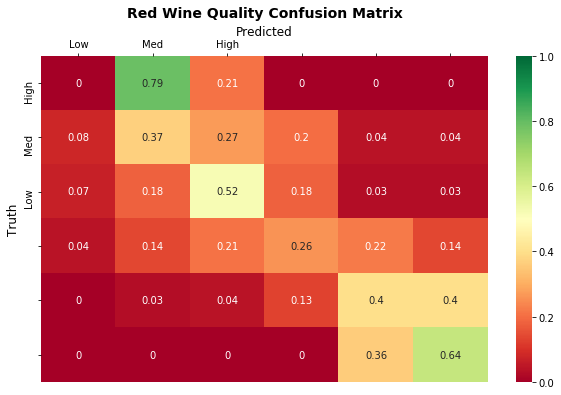

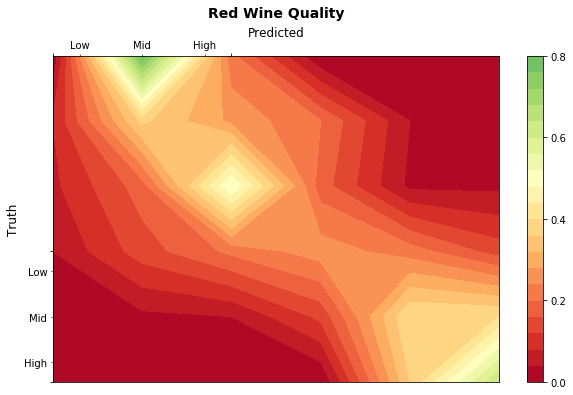

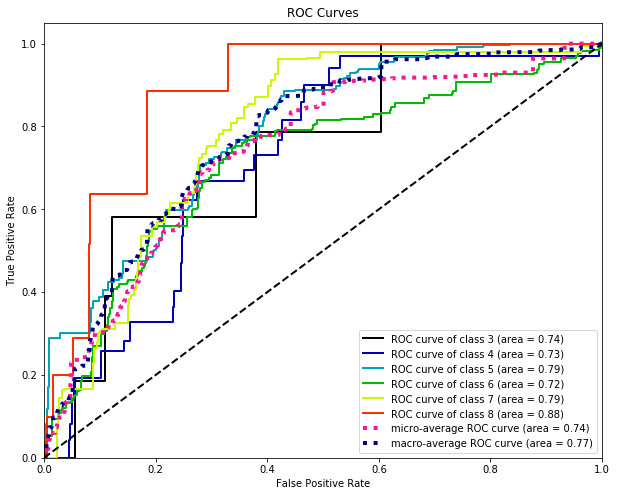

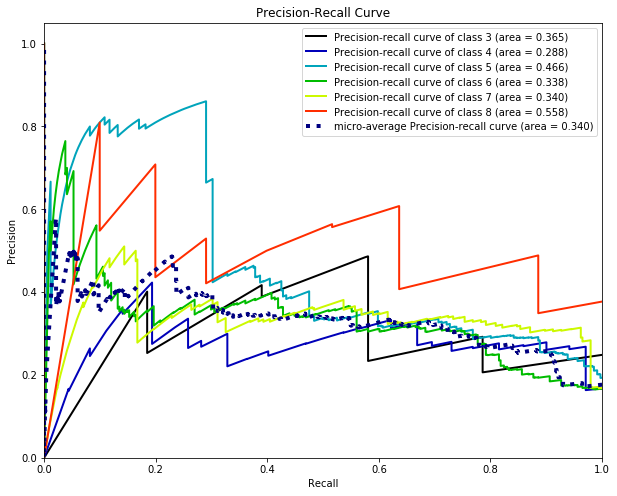

In [36]:
discrete_heatmap(confusion_matrix(y_test, lr5_pred))

interpolated_heatmap(confusion_matrix(y_test, lr5_pred))

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr5_probas, ax=ax)

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr5_probas, ax=ax)

In [37]:
pipe5 = make_pipeline(StandardScaler(), lr5)

pipe5.fit(X_train, y_train)

print(pipe5)

# make predictions
pipe5_pred = pipe5.predict(X_test)
pipe5_probas = pipe5.predict_proba(X_test)
pipe5_conf = pipe5.decision_function(X_test)

# summarize the fit of the model
print(classification_report(y_test, pipe5_pred))
print(confusion_matrix(y_test, pipe5_pred))

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=25000.0,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='sag', tol=0.0001, verbose=0,
          warm_start=False))])
             precision    recall  f1-score   support

          3       0.00      0.00      0.00       341
          4       0.36      0.52      0.43       341
          5       0.39      0.54      0.45       341
          6       0.38      0.34      0.36       341
          7       0.37      0.54      0.44       341
          8       0.53      0.42      0.47       341

avg / total       0.34      0.39      0.36      2046

[[  0 198 143   0   0   0]
 [ 10 176  67  62  14  12]
 [  4  53 183  81  15   5]
 [  2  43  64 117  90  25]
 [  0  14  13  44 185  85]
 [  0   0  

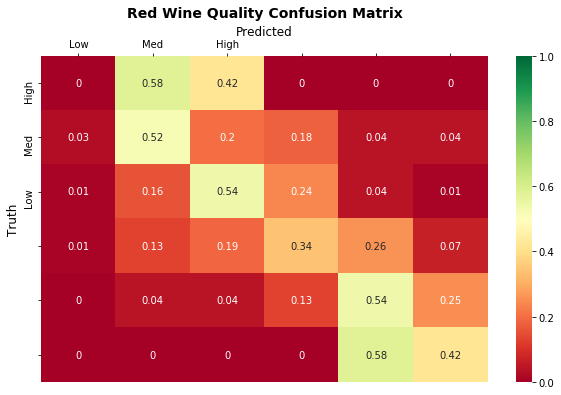

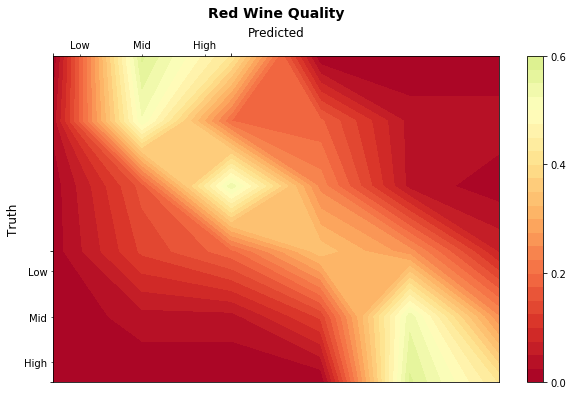

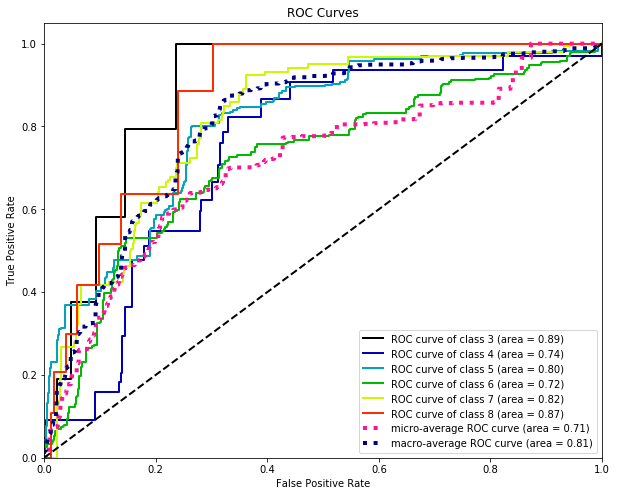

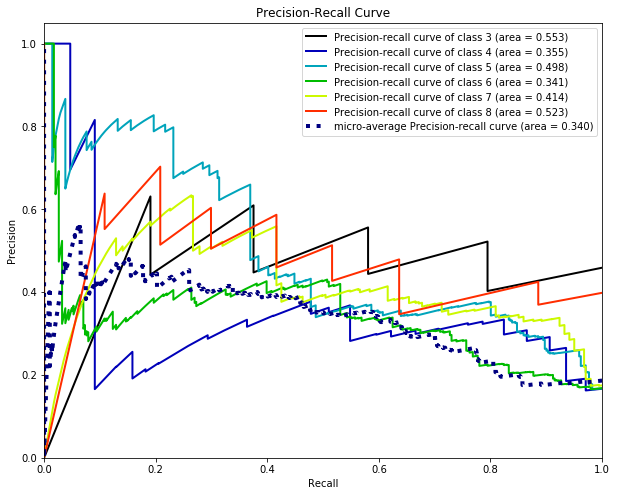

In [38]:
discrete_heatmap(confusion_matrix(y_test, pipe5_pred))

interpolated_heatmap(confusion_matrix(y_test, pipe5_pred))

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, pipe5_probas, ax=ax)

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, pipe5_probas, ax=ax)

In [39]:
lr6 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='saga',
                         max_iter=10000*2.5)
lr6.fit(X_train, y_train)

print(lr6)

# make predictions
lr6_pred = lr6.predict(X_test)
lr6_probas = lr6.predict_log_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr6_pred))
print(confusion_matrix(y_test, lr6_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=25000.0,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          3       0.00      0.00      0.00       341
          4       0.21      0.30      0.25       341
          5       0.42      0.52      0.46       341
          6       0.35      0.25      0.29       341
          7       0.35      0.38      0.37       341
          8       0.50      0.64      0.56       341

avg / total       0.31      0.35      0.32      2046

[[  0 268  73   0   0   0]
 [ 49 104  93  52  29  14]
 [ 28  56 176  61  13   7]
 [ 13  52  68  84  75  49]
 [  0   9  13  40 130 149]
 [  0   0   0   0 124 217]]


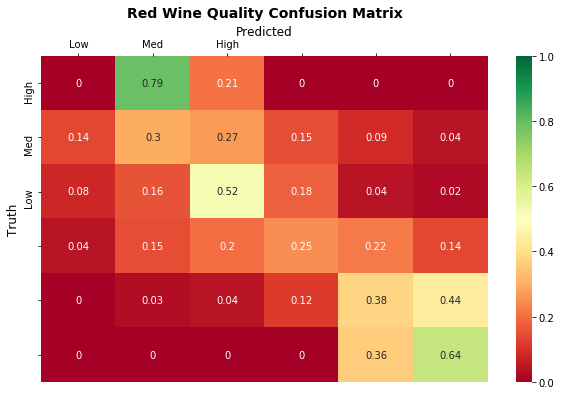

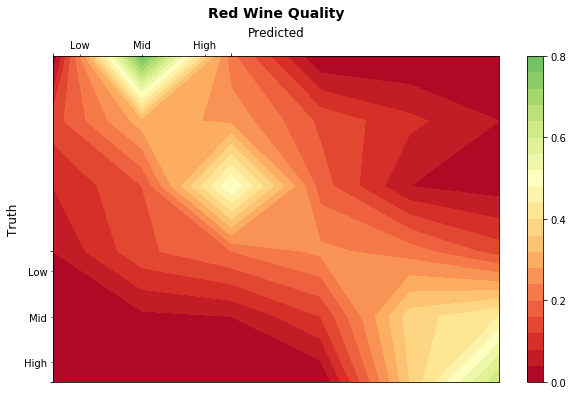

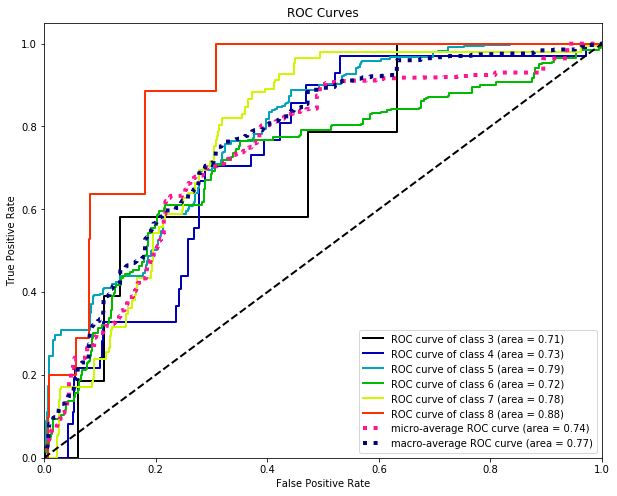

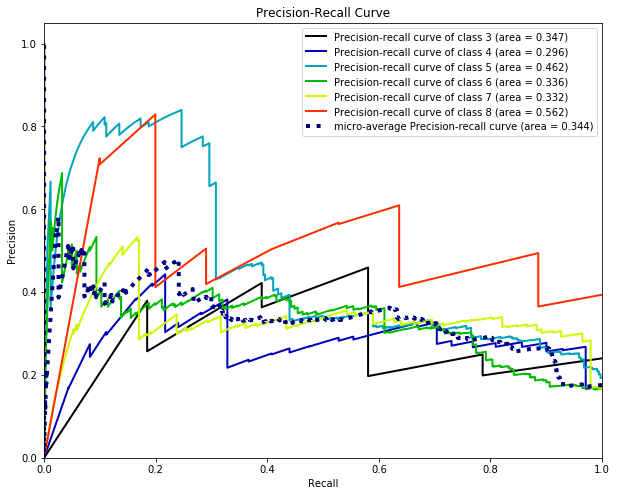

In [40]:
discrete_heatmap(confusion_matrix(y_test, lr6_pred))

interpolated_heatmap(confusion_matrix(y_test, lr6_pred))

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr6_probas, ax=ax)

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr6_probas, ax=ax)

In [41]:
pipe6 = make_pipeline(StandardScaler(), lr6)

pipe6.fit(X_train, y_train)

print(pipe6)

# make predictions
pipe6_pred = pipe6.predict(X_test)
pipe6_probas = pipe6.predict_proba(X_test)
pipe6_conf = pipe6.decision_function(X_test)

# summarize the fit of the model
print(classification_report(y_test, pipe6_pred))
print(confusion_matrix(y_test, pipe6_pred))

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=25000.0,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='saga', tol=0.0001, verbose=0,
          warm_start=False))])
             precision    recall  f1-score   support

          3       0.00      0.00      0.00       341
          4       0.36      0.52      0.43       341
          5       0.39      0.54      0.45       341
          6       0.38      0.34      0.36       341
          7       0.37      0.54      0.44       341
          8       0.53      0.42      0.47       341

avg / total       0.34      0.39      0.36      2046

[[  0 198 143   0   0   0]
 [ 10 176  67  62  14  12]
 [  4  53 183  81  15   5]
 [  0  45  64 117  90  25]
 [  0  14  13  44 185  85]
 [  0   0 

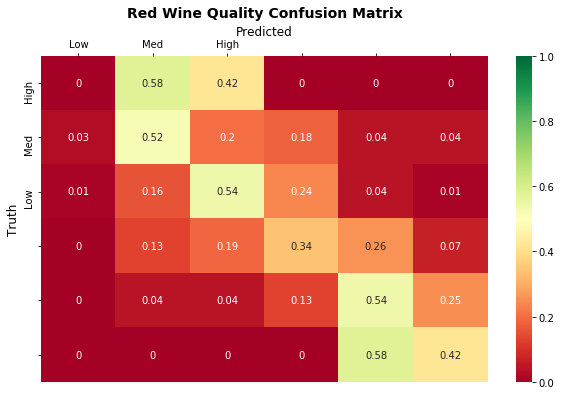

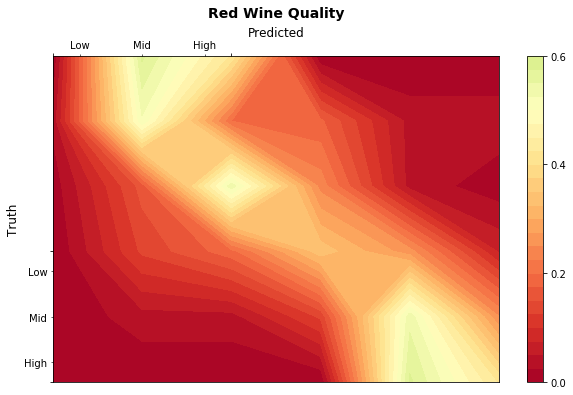

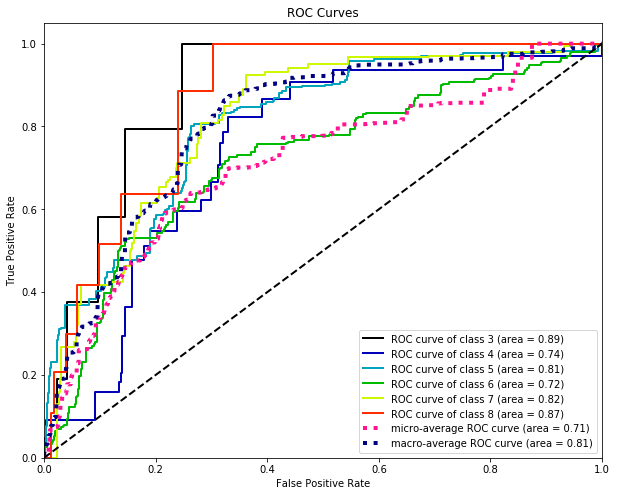

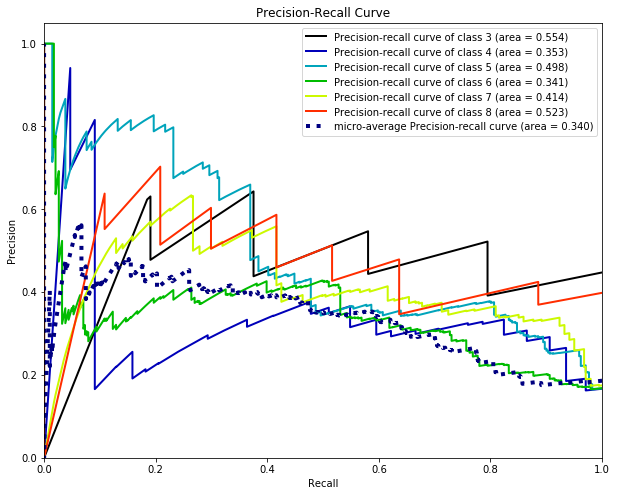

In [42]:
discrete_heatmap(confusion_matrix(y_test, pipe6_pred))

interpolated_heatmap(confusion_matrix(y_test, pipe6_pred))

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, pipe6_probas, ax=ax)

fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, pipe6_probas, ax=ax)